# Problem Statement: **AtliQ's Customer Churn Prediction**

### Welcome to AtliQ Electronics, a leading consumer electronics retailer! AtliQ has been facing customer churn issues and is building an AI-powered predictive model to identify customers likely to discontinue their services. However, the data science team observed that the model tends to overfit the training data, leading to poor generalization on new data. Your task is to implement and compare different regularization techniques to build a robust and accurate churn prediction model.


**References**

* Batchnorm1d (PyTorch): [Link](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


Imports and CUDA

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Let's do some revisoin first and test your basic understanding of this module!

Problem1: **Effect of L1 Regularization on Sparsity in AtliQ's AI Models**

AtliQ is optimizing its AI models to reduce unnecessary complexity. You are given the following weights from one of AtliQ's neural network layers:



```
weights = torch.tensor([0.5, -0.3, 0.8, -1.5], requires_grad=True)
```

Write a PyTorch snippet to compute the L1 regularization term ``` (|w1| + |w2| + ...) ``` and calculate its gradient using backward().


In [5]:
# weights
weights = torch.tensor([0.5,-0.3,0.8,-1.5],requires_grad=True)

# Compute L1 regularization term
l1_regularization = torch.sum(torch.abs(weights))

# compute gradients
l1_regularization.backward()
# Output gradients
print(f"L1 Regularization: {l1_regularization.item():.4f}")
print(f"Gradients: {weights.grad}")

L1 Regularization: 3.1000
Gradients: tensor([ 1., -1.,  1., -1.])




---



Problem2: **Batch Normalization of AtliQ's Marketing Data**

AtliQ has collected a mini-batch of marketing data:

`inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])`

Manually implement the forward pass of Batch Normalization. Normalize the data using:

$$Normalized= X-μ / σ$$

Here, μ is the mean of each feature, and σ is the standard deviation.

Write code to compute the normalized data without using `nn.BatchNorm`.





In [8]:
# inputs
inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])

# compute mean and standard deviation along each column (feature)
mean = inputs.mean(dim=0)
std = inputs.std(dim=0)

# normalize the input
normalized =(inputs-mean)/std

print(f"Inputs:\n{inputs}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Normalized Outputs:\n{normalized}")

Inputs:
tensor([[10., 20.],
        [15., 25.],
        [12., 18.]])
Mean: tensor([12.3333, 21.0000])
Standard Deviation: tensor([2.5166, 3.6056])
Normalized Outputs:
tensor([[-0.9272, -0.2774],
        [ 1.0596,  1.1094],
        [-0.1325, -0.8321]])




---



### Task: **AtliQ's Customer Churn Prediction**



**Dataset Description**

You are provided with 5000 customer records and 6 features that describe customer behavior over the past 12 months. The provided dataset (**AtliQ_Churn_Prediction_Codebasics_DL.csv)** includes the following attributes:

* Purchase_History
* Support_Tickets
* Last_Purchase_Months
* Product_Categories
* Satisfaction_Score
* Discount_Usage_Rate

Target Variable:

* Churned: 1 if the customer has churned, 0 otherwise.

**Step1**: Load and Prepare the Dataset

In [15]:
# Load dataset
data = pd.read_csv("AtliQ_Churn_Prediction_Codebasics_DL.csv")

# Separate features and target
x = data.drop("Churned", axis=1).values
y = data['Churned'].values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Purchase_History      5000 non-null   int64  
 1   Support_Tickets       5000 non-null   int64  
 2   Last_Purchase_Months  5000 non-null   int64  
 3   Product_Categories    5000 non-null   int64  
 4   Satisfaction_Score    5000 non-null   float64
 5   Discount_Usage_Rate   5000 non-null   float64
 6   Churned               5000 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 273.6 KB




---



**Step2**: Split the Dataset

Train : Test :: 70 : 30



---



In [16]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=32)



---



**Step3**: Normalize the features



In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)



---



**Step4**: Convert to PyTorch Tensors

In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



---



**Step5**: Build a Base Model (without regularization)

Details:
* Input layer: 6 features
* Hidden layers: Two layers with 32 and 16 neurons (ReLU activation)
* Output layer: 1 neuron (Sigmoid activation for binary classification)
* Train for 30 epochs, batch size = 32, learning rate = 0.01.
* Use **BCELoss** and **SGD** as Optimizer

In [24]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6,32),  #input +hid1
            nn.ReLU(),
            nn.Linear(32,16),#Input hid2
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        return self.network(x)

model = BaseModel()
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)




---



**Step6**: Train the Base Model

* epochs = 30
* batch size = 32

Epoch 1, Training Loss: 0.6165, Validation Loss: 0.6160
Epoch 2, Training Loss: 0.6154, Validation Loss: 0.6156
Epoch 3, Training Loss: 0.6149, Validation Loss: 0.6155
Epoch 4, Training Loss: 0.6146, Validation Loss: 0.6154
Epoch 5, Training Loss: 0.6144, Validation Loss: 0.6153
Epoch 6, Training Loss: 0.6142, Validation Loss: 0.6153
Epoch 7, Training Loss: 0.6141, Validation Loss: 0.6152
Epoch 8, Training Loss: 0.6139, Validation Loss: 0.6152
Epoch 9, Training Loss: 0.6138, Validation Loss: 0.6152
Epoch 10, Training Loss: 0.6137, Validation Loss: 0.6152
Epoch 11, Training Loss: 0.6136, Validation Loss: 0.6151
Epoch 12, Training Loss: 0.6135, Validation Loss: 0.6151
Epoch 13, Training Loss: 0.6134, Validation Loss: 0.6151
Epoch 14, Training Loss: 0.6134, Validation Loss: 0.6151
Epoch 15, Training Loss: 0.6133, Validation Loss: 0.6151
Epoch 16, Training Loss: 0.6132, Validation Loss: 0.6151
Epoch 17, Training Loss: 0.6132, Validation Loss: 0.6151
Epoch 18, Training Loss: 0.6131, Validat

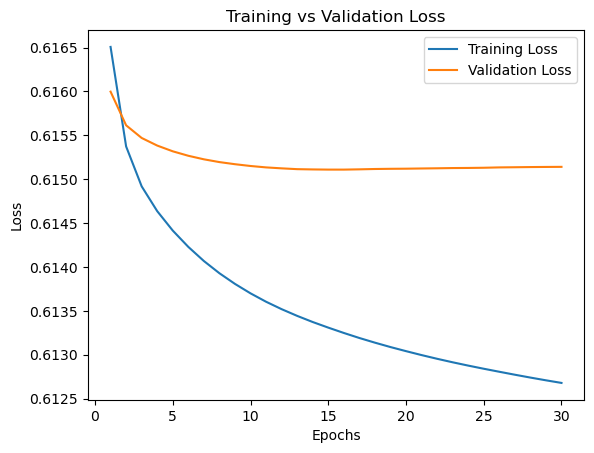

In [27]:
# Train the model
epochs =30
batch_size =32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred,y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_function(val_predictions,y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



---



**Step7**: Implement Dropout Regularization

Modify the base model to include dropout layers after each dense layer.
* Experiment with dropout rate 0.4.

In [28]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

dropout_model = DropoutModel()
optimizer_dropout = optim.SGD(dropout_model.parameters(), lr=0.01)




---



**Step8**: Training Process for Dropout Regularization

Epoch 1, Training Loss: 0.6448, Validation Loss: 0.6312
Epoch 2, Training Loss: 0.6299, Validation Loss: 0.6227
Epoch 3, Training Loss: 0.6238, Validation Loss: 0.6196
Epoch 4, Training Loss: 0.6231, Validation Loss: 0.6187
Epoch 5, Training Loss: 0.6199, Validation Loss: 0.6180
Epoch 6, Training Loss: 0.6193, Validation Loss: 0.6176
Epoch 7, Training Loss: 0.6201, Validation Loss: 0.6173
Epoch 8, Training Loss: 0.6198, Validation Loss: 0.6173
Epoch 9, Training Loss: 0.6186, Validation Loss: 0.6171
Epoch 10, Training Loss: 0.6192, Validation Loss: 0.6170
Epoch 11, Training Loss: 0.6168, Validation Loss: 0.6169
Epoch 12, Training Loss: 0.6165, Validation Loss: 0.6169
Epoch 13, Training Loss: 0.6155, Validation Loss: 0.6168
Epoch 14, Training Loss: 0.6156, Validation Loss: 0.6167
Epoch 15, Training Loss: 0.6150, Validation Loss: 0.6166
Epoch 16, Training Loss: 0.6145, Validation Loss: 0.6166
Epoch 17, Training Loss: 0.6139, Validation Loss: 0.6166
Epoch 18, Training Loss: 0.6161, Validat

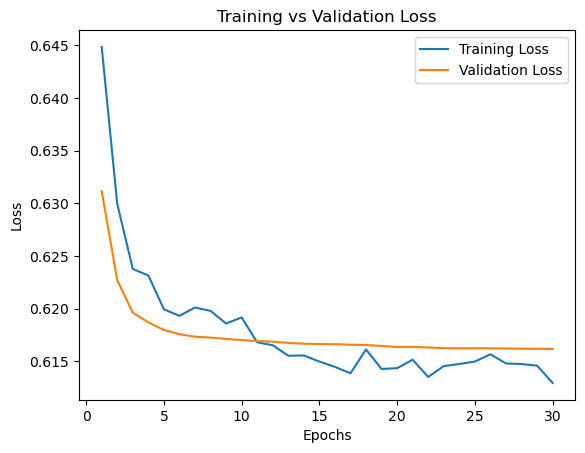

In [30]:
# Train the model for Dropout Regularization (Similar training process as above)
epochs =30
batch_size =32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    dropout_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_dropout.zero_grad()
        y_pred = dropout_model(X_batch)
        loss = loss_function(y_pred,y_batch)
        loss.backward()
        optimizer_dropout.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    dropout_model.eval()
    with torch.no_grad():
        val_predictions = dropout_model(X_test_tensor)
        val_loss = loss_function(val_predictions,y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



---



**Step9**: Apply L2 Regularization

* Use `torch.optim.SGD` with `weight_decay=0.1` for L2 regularization.
* Train the model and monitor validation loss and accuracy.

Epoch 1, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 2, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 3, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 4, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 5, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 6, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 7, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 8, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 9, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 10, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 11, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 12, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 13, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 14, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 15, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 16, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 17, Training Loss: 0.6130, Validation Loss: 0.6162
Epoch 18, Training Loss: 0.6130, Validat

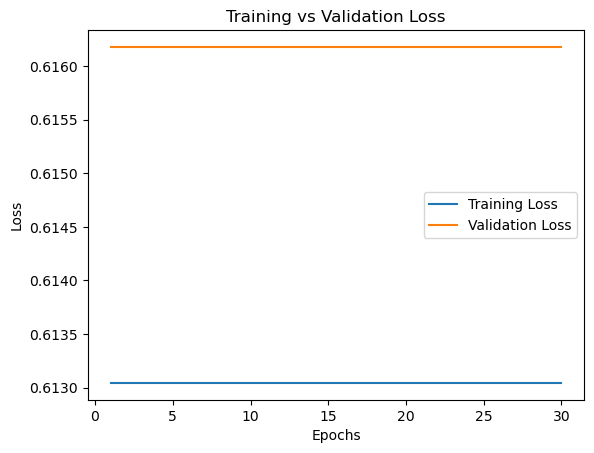

In [32]:
# L2 regularization (weight decay)
optimizer_l2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

# Train the model for L2 Regularization (Similar training process as above)
epochs =30
batch_size =32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train() # model will remain the same
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_l2.zero_grad()
        y_pred = dropout_model(X_batch)
        loss = loss_function(y_pred,y_batch)
        loss.backward()
        optimizer_l2.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = dropout_model(X_test_tensor)
        val_loss = loss_function(val_predictions,y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()




---



**Step10**: Add Batch Normalization

* use BatchNorm1d
* use **SGD** Optimizer with learning rate = 0.01

In [33]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 32),
            # Batch normalization
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Train the BatchNormModel
batchnorm_model = BatchNormModel()
optimizer_bn = optim.SGD(batchnorm_model.parameters(), lr=0.01)




---



**Step11**: Training Process for Batch Normalization

In [34]:
# Train the model for Batch Normalization (Similar training process as above)
epochs =30
batch_size =32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    batchnorm_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_bn.zero_grad()
        y_pred = batchnorm_model(X_batch)
        loss = loss_function(y_pred,y_batch)
        loss.backward()
        optimizer_bn.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    batchnorm_model.eval()
    with torch.no_grad():
        val_predictions = batchnorm_model(X_test_tensor)
        val_loss = loss_function(val_predictions,y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x6 and 5x32)

In [35]:
# Train the model for Batch Normalization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    batchnorm_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_bn.zero_grad()
        y_pred = batchnorm_model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_bn.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    batchnorm_model.eval()
    with torch.no_grad():
        val_predictions = batchnorm_model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x6 and 5x32)



---

